# Lab 3 - Part 2: Word and Sentence Embeddings

**Objectives:**
- Understand and implement Word2Vec (CBOW and Skip-gram)
- Work with pre-trained GloVe embeddings
- Use BERT for sentence embeddings
- Compare different embedding approaches
- Apply embeddings to find similar words and documents

---

## Instructions

1. Complete all exercises marked with `# YOUR CODE HERE`
2. **Answer all written questions** in the designated markdown cells
3. Save your completed notebook
4. **Push to your Git repository and send the link to: yoroba93@gmail.com**

### Important: This lab continues from Part 1

You will use the same dataset and categories you chose in Part 1.

---

## Setup

In [37]:
!pip install gensim

In [ ]:
# Install required libraries (uncomment if needed)
# !pip install gensim transformers torch sentence-transformers datasets

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import re
import string
import warnings
warnings.filterwarnings('ignore')

import nltk
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import gensim
from gensim.models import Word2Vec, KeyedVectors
import gensim.downloader as api

print(f"Gensim version: {gensim.__version__}")
print("Setup complete!")

Gensim version: 4.4.0
Setup complete!


## Load Dataset (Same as Part 1)

In [39]:
import pandas as pd

# Load the dataset
df = pd.read_csv('/content/20_newsgroups_train.csv')

# TODO: Use the SAME 3 categories you chose in Part 1!
my_categories = ["alt.atheism", "comp.graphics", "sci.space"]  # COPY FROM PART 1

# Filter dataset
df_filtered = df[df['label_text'].isin(my_categories)].copy()
df_filtered = df_filtered.reset_index(drop=True)

print(f"Selected categories: {my_categories}")
print(f"Filtered dataset size: {len(df_filtered)}")

Selected categories: ['alt.atheism', 'comp.graphics', 'sci.space']
Filtered dataset size: 1657


In [40]:
import nltk

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [41]:
# Preprocessing function (same as Part 1)
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    """Preprocess text for embedding training."""
    #text = "" # YOUR CODE HERE  => the same as in Part 1 (advanced preprocessing)
    #tokens = []  # YOUR CODE HERE  => the same as in Part 1 (advanced preprocessing)
    #return tokens  # Return list of tokens for Word2Vec
    # Step 1: Basic cleaning
    if not isinstance(text, str):
        return []

    # Step 1: Basic cleaning
    text = text.lower()
    text = re.sub(r'\S+@\S+', '', text)
    text = re.sub(r'http\S+|www\S+', '', text)
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Step 2: Tokenize (regex-based, no NLTK punkt)
    tokens = re.findall(r'\b[a-z]+\b', text)

    # Step 3: Remove stop words
    tokens = [w for w in tokens if w not in stop_words]

    # Step 4: Lemmatize
    tokens = [lemmatizer.lemmatize(w) for w in tokens]

    # Step 5: Remove short words (< 3 chars)
    tokens = [w for w in tokens if len(w) >= 3]

    return tokens

# Apply preprocessing
df_filtered['tokens'] = df_filtered['text'].apply(preprocess_text)
df_filtered['text_clean'] = df_filtered['tokens'].apply(' '.join)

print(f"Sample tokens: {df_filtered.iloc[0]['tokens'][:20]}")


Sample tokens: ['weiteks', 'addressphone', 'number', 'like', 'get', 'information', 'chip']


---

## Part A: Word2Vec - Training Your Own Embeddings

Word2Vec learns word representations by predicting context. There are two architectures:
- **CBOW (Continuous Bag of Words)**: Predicts target word from context words
- **Skip-gram**: Predicts context words from target word

### A.1 Understanding Word2Vec Architectures

In [42]:
# Prepare corpus for Word2Vec (list of tokenized sentences)
corpus = df_filtered['tokens'].tolist()

print(f"Corpus size: {len(corpus)} documents")
print(f"Total tokens: {sum(len(doc) for doc in corpus)}")
print(f"\nSample document tokens: {corpus[0][:15]}")

Corpus size: 1657 documents
Total tokens: 158687

Sample document tokens: ['weiteks', 'addressphone', 'number', 'like', 'get', 'information', 'chip']


In [43]:
# Train Word2Vec with CBOW (sg=0)
model_cbow = Word2Vec(
    sentences=corpus,
    vector_size=100,      # Embedding dimension
    window=5,             # Context window size
    min_count=5,          # Ignore words with freq < 5
    workers=4,            # Parallel threads
    sg=0,                 # 0 = CBOW, 1 = Skip-gram
    epochs=10             # Training epochs
)

print(f"CBOW Model trained!")
print(f"Vocabulary size: {len(model_cbow.wv)}")

CBOW Model trained!
Vocabulary size: 4745


In [44]:
# Train Word2Vec with Skip-gram (sg=1)
model_skipgram = Word2Vec(
    sentences=corpus,
    vector_size=100,
    window=5,
    min_count=5,
    workers=4,
    sg=1,                 # Skip-gram
    epochs=10
)

print(f"Skip-gram Model trained!")
print(f"Vocabulary size: {len(model_skipgram.wv)}")

Skip-gram Model trained!
Vocabulary size: 4745


### A.2 Exploring Word Embeddings

In [45]:
# Example: Get word vector
sample_word = "computer"  # Change this to a word relevant to YOUR categories

if sample_word in model_cbow.wv:
    vector = model_cbow.wv[sample_word]
    print(f"Vector for '{sample_word}':")
    print(f"  Shape: {vector.shape}")
    print(f"  First 10 values: {vector[:10]}")
else:
    print(f"'{sample_word}' not in vocabulary. Try another word.")
    print(f"Sample words in vocab: {list(model_cbow.wv.key_to_index.keys())[:20]}")

Vector for 'computer':
  Shape: (100,)
  First 10 values: [-0.8928408   0.8846241   0.7422608  -0.67154706  0.1874886  -0.6199554
  0.11242337  0.7537508  -0.4629527  -0.2601366 ]


In [46]:
# Find similar words
sample_word = "computer"  # Change to a word in YOUR vocabulary

if sample_word in model_cbow.wv:
    print(f"\nWords most similar to '{sample_word}' (CBOW):")
    for word, score in model_cbow.wv.most_similar(sample_word, topn=10):
        print(f"  {word}: {score:.4f}")

    print(f"\nWords most similar to '{sample_word}' (Skip-gram):")
    for word, score in model_skipgram.wv.most_similar(sample_word, topn=10):
        print(f"  {word}: {score:.4f}")


Words most similar to 'computer' (CBOW):
  user: 0.9840
  application: 0.9763
  database: 0.9755
  visualization: 0.9661
  tool: 0.9635
  analysis: 0.9614
  processing: 0.9613
  plotting: 0.9611
  nbdsp: 0.9599
  interactive: 0.9595

Words most similar to 'computer' (Skip-gram):
  exponent: 0.7873
  graeme: 0.7350
  switzerland: 0.7310
  art: 0.7190
  berlin: 0.7157
  molecular: 0.7131
  network: 0.7128
  silicon: 0.7077
  gem: 0.7035
  sutherland: 0.7007


### Exercise A.1: Compare CBOW vs Skip-gram

Choose **5 words that are relevant to YOUR 3 categories** and compare the most similar words from both models.

In [47]:
# TODO: Choose 5 words relevant to YOUR categories
# These should be domain-specific words (not common words like "good", "make", etc.)

my_test_words = ["exponent", "graphic", "interactive", "switzerland", "network"]  # YOUR WORDS HERE

comparison_results = []

for word in my_test_words:
    word = word.lower()
    if word in model_cbow.wv and word in model_skipgram.wv:
        cbow_similar = [w for w, s in model_cbow.wv.most_similar(word, topn=5)]
        skipgram_similar = [w for w, s in model_skipgram.wv.most_similar(word, topn=5)]

        comparison_results.append({
            'word': word,
            'cbow_top5': cbow_similar,
            'skipgram_top5': skipgram_similar
        })

        print(f"\n'{word}':")
        print(f"  CBOW:     {cbow_similar}")
        print(f"  Skip-gram: {skipgram_similar}")
    else:
        print(f"'{word}' not found in vocabulary!")


'exponent':
  CBOW:     ['gem', 'processor', 'raytracers', 'optional', 'indigo']
  Skip-gram: ['gem', 'silicon', 'procedural', 'cad', 'beta']

'graphic':
  CBOW:     ['package', 'library', 'software', 'run', 'window']
  Skip-gram: ['exponent', 'gem', 'radiosity', 'cad', 'raytracing']

'interactive':
  CBOW:     ['digital', 'sphinx', 'environment', 'visualization', 'nbdsp']
  Skip-gram: ['widget', 'computation', 'gui', 'visualisation', 'hip']

'switzerland':
  CBOW:     ['academic', 'pace', 'seminar', 'institution', 'nssdc']
  Skip-gram: ['ltd', 'wavefront', 'bibliography', 'marc', 'stanford']

'network':
  CBOW:     ['kit', 'environment', 'ephemeris', 'capability', 'integrated']
  Skip-gram: ['cray', 'ibmpc', 'aips', 'integrated', 'runtime']


### Written Question A.1 (Personal Interpretation)

Based on your comparison above:

1. **For which words did CBOW and Skip-gram give SIMILAR results?**
2. **For which words did they give DIFFERENT results?**
3. **Which model seems to capture better semantic relationships for YOUR specific domain?** Explain with examples.
4. **Why might one model work better than the other for certain types of words?** (Think about word frequency)

**YOUR ANSWER:**

1. Similar results for: ...

  graphic

CBOW: package, library, software, workshop, run

Skip-gram: exponent, gem, cad, programming, indigo

Why similar?

Both models associate graphic with software / computing / visualization-related terms.

Even though the exact words differ, they live in the same semantic neighborhood (graphics software, programming, CAD, visualization).

👉 Conclusion:
Semantically similar, stylistically different.

🔹 interactive

CBOW: digital, visualization, map, quantitative, various

Skip-gram: widget, visualisation, gui, computation, kernel

Why similar?

Both models strongly associate interactive with:

visualization

computation

user interfaces

CBOW is more abstract, Skip-gram is more technical, but the meaning overlaps strongly.

👉 Conclusion:
High semantic agreement.

🔹 network

CBOW: distributed, spyglass, environment, ibm, datasets

Skip-gram: ibmpc, aips, geographic, nbdsp, visualisation

Why similar?

Both models associate network with:

computing

enterprise / IBM-related terms

data environments

Skip-gram gives more specific technical artifacts, CBOW stays broader.

👉 Conclusion:
Same domain, different granularity → still similar.

✅ Words with SIMILAR results

graphic

interactive

network


----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


2. Different results for: ...

  exponent

CBOW: linear, nonlinear, lisp, phigs, graeme

Skip-gram: silicon, gem, procedural, flexibility, iris

Why different?

CBOW links exponent to mathematical / theoretical concepts.

Skip-gram links it to hardware, materials, and procedural contexts.

👉 Clear semantic divergence.

🔸 switzerland

CBOW: fee, institution, academic, cambridge, guide

Skip-gram: ltd, campus, sigkids, jay, tel

Why different?

CBOW associates Switzerland with academia and institutions.

Skip-gram associates it with organizations, locations, and entities.

👉 Different contextual interpretations of the same word.

❌ Words with DIFFERENT results

exponent

switzerland

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


3. Better model for my domain: ...
   - Example 1: ...
   - Example 2: ...



   Skip-gram performs better overall for your domain

Your domain appears to be:

    technical

    academic

    computing / visualization / software-oriented

🔍 Evidence from your results:
Word	Why Skip-gram is better
interactive	widget, gui, kernel → strong technical semantics
graphic	cad, programming, gem → domain-specific tools
network	ibmpc, visualisation → concrete technical entities

Skip-gram captures fine-grained, domain-specific semantics, which is ideal for:

    technical corpora

    academic papers

    software documentation
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------



4. Explanation of differences: ...
CBOW is better for frequent words
Skip-gram is better for rare or technical words.

CBOW (Continuous Bag of Words)

Predicts a word from its context Averages surrounding words

Advantages:

    Fast

    Stable

    Works well for high-frequency words

Disadvantages:

    Loses nuance

    Less precise for rare terms

📌 Example from your results:

    interactive → digital, various

    Broad, generic associations


Skip-gram:
    Predicts context from a word
    Learns each context independently

  Advantages:

    Excellent for rare words

    Captures precise semantic relations

  Disadvantages:

    Slower

    Needs more data

📌 Example from your results:

    interactive → widget, gui

    graphic → cad

    Much more informative for technical NLP tasks

### A.3 Word Analogies

In [48]:
# Example: Word analogies (king - man + woman = queen)
# This works better with larger, pre-trained models, but let's try with our custom model

def find_analogy(model, word1, word2, word3):
    """
    Find word that completes analogy: word1 is to word2 as word3 is to word4
    Uses: word2 - word1 + word3 = word4
    """
    try:
        result = model.wv.most_similar(
            positive=[word2, word3],
            negative=[word1],
            topn=5
        )
        return result
    except KeyError as e:
        return f"Word not found: {e}"

# Test with your domain
# Example: "baseball" is to "bat" as "hockey" is to ?
print("Analogy test (your model may have limited vocabulary):")
#result = find_analogy(model_skipgram, "word1", "word2", "word3")
result = find_analogy(model_skipgram, "programming", "code", "visualization")
# Expected: "plot", "graphic", "chart"

print(result)

Analogy test (your model may have limited vocabulary):
[('generator', 0.6813595294952393), ('ansi', 0.6579309105873108), ('fortran', 0.6467586159706116), ('license', 0.6460633277893066), ('distributed', 0.6442937850952148)]


In [49]:
result = find_analogy(model_skipgram, "gui", "widget", "interactive")
print(result,'\n')

result = find_analogy(model_skipgram, "data", "dataset", "network")
print(result,'\n')
result = find_analogy(model_skipgram, "university", "academic", "institution")
print(result,'\n')

[('visualization', 0.8757232427597046), ('computational', 0.8608754277229309), ('visualisation', 0.8576482534408569), ('svlib', 0.8574979901313782), ('computation', 0.8512306213378906)] 

Word not found: "Key 'dataset' not present in vocabulary" 

[('bulletin', 0.8600651025772095), ('variety', 0.8585644960403442), ('maintained', 0.8501346111297607), ('yee', 0.8448836207389832), ('daily', 0.8448034524917603)] 



### Exercise A.2: Create Domain-Specific Analogies

Try to find **2 analogies** that work with YOUR dataset's vocabulary.

In [50]:
# TODO: Try 2 analogies with words from YOUR vocabulary
# Format: word1 is to word2 as word3 is to ?

# Analogy 1
# YOUR CODE HERE
analogy1 = find_analogy(model_skipgram, "programming","code","visualization")
print(f"Analogy 1: {analogy1}")

# Analogy 2
# YOUR CODE HERE
analogy2 = find_analogy(model_skipgram, "gui","widget","interactive")
print(f"Analogy 2: {analogy2}")

Analogy 1: [('generator', 0.6813595294952393), ('ansi', 0.6579309105873108), ('fortran', 0.6467586159706116), ('license', 0.6460633277893066), ('distributed', 0.6442937850952148)]
Analogy 2: [('visualization', 0.8757232427597046), ('computational', 0.8608754277229309), ('visualisation', 0.8576482534408569), ('svlib', 0.8574979901313782), ('computation', 0.8512306213378906)]


### Written Question A.2 (Personal Interpretation)

**Did your analogies work?**
- If yes, explain why the result makes sense.
- If no, explain why they might have failed (vocabulary size, training data, etc.)

**YOUR ANSWER:**



Analogy 2 worked reasonably well; Analogy 1 did not work cleanly.
    generator, license, distributed, ansi, manual
Did it work?

Mostly NO (weak / noisy result).

Why it didn’t work well:

  Vocabulary limitation:
    Your corpus likely does not contain enough consistent examples of “visualization → output” relationships (e.g., plot, chart, graphic used in parallel with code).

  Conceptual mismatch:
    code is a concrete artifact of programming.

    visualization in your dataset appears more often in documentation / standards / libraries, not as a producer of a single concrete object.

  Small / domain-specific corpus:
    Analogy reasoning relies on linear semantic offsets, which typically emerge only in large, diverse corpora.

  Skip-gram captured context, not analogy structure
    Words like generator, ansi, and manual reflect technical documentation contexts, not visualization outputs.
Conclusion:
    The analogy failed because the semantic relationship (produces) was not consistently encoded in the training data.

Analogy 2: GUI → widget :: interactive → ?
visualization, svlib, kernel, silicon, motif
Did it work?

    YES (partially successful and meaningful).

Why this result makes sense:

   Strong semantic overlap

    GUIs are built from widgets

   Interactive systems are strongly associated with:

    visualization

    kernel (backend computation)

    motif (UI toolkit)

Your earlier similarity results support this
You already observed:
    interactive → widget, gui, visualization
So the analogy aligns with existing semantic clusters.

Skip-gram is particularly good at:

    capturing technical, low-frequency words

    modeling component-level relationships

...


---

## Part B: Pre-trained GloVe Embeddings

GloVe (Global Vectors) is trained on much larger corpora and captures broader relationships.

In [ ]:
# Load pre-trained GloVe embeddings (this may take a few minutes)
print("Loading GloVe embeddings (this may take a minute)...")
glove_model = api.load('glove-wiki-gigaword-100')  # 100-dimensional vectors
print(f"GloVe loaded! Vocabulary size: {len(glove_model)}")

Loading GloVe embeddings (this may take a minute)...
[==================================================] 100.0% 128.1/128.1MB downloaded
GloVe loaded! Vocabulary size: 400000


In [51]:
# Compare: Same word in YOUR model vs GloVe
test_word = "computer"  # Change to a word relevant to your domain

print(f"Similar words to '{test_word}':")
print("\nYour Word2Vec model:")
if test_word in model_skipgram.wv:
    for word, score in model_skipgram.wv.most_similar(test_word, topn=10):
        print(f"  {word}: {score:.4f}")
else:
    print(f"  '{test_word}' not in vocabulary")

print("\nPre-trained GloVe:")
if test_word in glove_model:
    for word, score in glove_model.most_similar(test_word, topn=10):
        print(f"  {word}: {score:.4f}")
else:
    print(f"  '{test_word}' not in vocabulary")

Similar words to 'computer':

Your Word2Vec model:
  exponent: 0.7873
  graeme: 0.7350
  switzerland: 0.7310
  art: 0.7190
  berlin: 0.7157
  molecular: 0.7131
  network: 0.7128
  silicon: 0.7077
  gem: 0.7035
  sutherland: 0.7007

Pre-trained GloVe:
  computers: 0.8752
  software: 0.8373
  technology: 0.7642
  pc: 0.7366
  hardware: 0.7290
  internet: 0.7287
  desktop: 0.7234
  electronic: 0.7222
  systems: 0.7198
  computing: 0.7142


### Exercise B.1: Compare Your Model vs GloVe

For **3 words from your domain**, compare the similar words from your trained model vs GloVe.

In [52]:
# TODO: Compare 3 domain-specific words

comparison_words = ["exponent", "switzerland", "network"]  # YOUR WORDS

for word in comparison_words:
    word = word.lower()
    print(f"\n{'='*50}")
    print(f"Word: '{word}'")
    print(f"{'='*50}")

    # Your model
    print("Your Word2Vec:")
    if word in model_skipgram.wv:
        for w, s in model_skipgram.wv.most_similar(word, topn=5):
            print(f"  {w}: {s:.3f}")
    else:
        print("  Not in vocabulary")

    # GloVe
    print("GloVe:")
    if word in glove_model:
        for w, s in glove_model.most_similar(word, topn=5):
            print(f"  {w}: {s:.3f}")
    else:
        print("  Not in vocabulary")


Word: 'exponent'
Your Word2Vec:
  gem: 0.936
  silicon: 0.915
  procedural: 0.906
  cad: 0.904
  beta: 0.903
GloVe:
  exponents: 0.538
  unitary: 0.499
  originator: 0.463
  indices: 0.457
  indicator: 0.456

Word: 'switzerland'
Your Word2Vec:
  ltd: 0.954
  wavefront: 0.949
  bibliography: 0.940
  marc: 0.938
  stanford: 0.935
GloVe:
  austria: 0.789
  germany: 0.779
  belgium: 0.757
  swiss: 0.743
  netherlands: 0.727

Word: 'network'
Your Word2Vec:
  cray: 0.905
  ibmpc: 0.903
  aips: 0.901
  integrated: 0.901
  runtime: 0.900
GloVe:
  networks: 0.904
  cable: 0.807
  channel: 0.784
  broadcast: 0.742
  channels: 0.740


### Written Question B.1 (Personal Interpretation)

Compare your custom-trained Word2Vec model with pre-trained GloVe:

1. **For which words does YOUR model give better (more relevant) similar words than GloVe?** Why?
2. **For which words does GloVe give better results?** Why?
3. **When would you use a custom-trained model vs a pre-trained model in a real project?**

**YOUR ANSWER:**

1. My model is better for: ...
   - Reason: ...
   My model is better for:

    exponent

    network

Reason:

    My custom Word2Vec model was trained on a technical and domain-specific corpus, so it captures contextual usage within that domain rather than general language meaning.

    For exponent, my model associates the word with technical and computational contexts such as silicon, procedural, and gem, which are relevant in computing, graphics, and hardware-related documentation.

    For network, the model retrieves technology-specific terms like ibmpc, aips, and visualisation, which align well with how “network” is used in technical and computing literature.

These results reflect domain relevance, even though they may not match dictionary-style meanings.

2. GloVe is better for: ...
   - Reason: ...

GloVe is better for:

  switzerland

  Reason:

    GloVe is trained on very large, general-purpose corpora (e.g., Wikipedia and Common Crawl), making it better at capturing geographic and world-knowledge relationships.

    For switzerland, GloVe correctly retrieves neighboring countries and related terms (Austria, Germany, Belgium, Swiss), which reflects real-world semantic knowledge.

    My custom model instead returns organization- and dataset-specific tokens (ltd, campus, tel), indicating limited exposure to geographic context.


3. When to use each:
   - Custom model: ...

    When working with domain-specific data (technical documents, academic papers, software manuals)

    When vocabulary contains specialized or rare terms

    When contextual meaning differs from general language usage.
    Example: scientific, engineering, or enterprise datasets

   - Pre-trained model: ...
    When working with general language understanding

    When tasks rely on world knowledge (countries, people, common concepts)

    When the dataset is small or lacks diversity
    Example: chatbots, news analysis, sentiment analysis

### B.2 GloVe Analogies

In [53]:
# Famous analogy: king - man + woman = queen
result = glove_model.most_similar(positive=['king', 'woman'], negative=['man'], topn=5)
print("king - man + woman = ?")
for word, score in result:
    print(f"  {word}: {score:.4f}")

king - man + woman = ?
  queen: 0.7699
  monarch: 0.6843
  throne: 0.6756
  daughter: 0.6595
  princess: 0.6521


In [54]:
# TODO: Try 3 more analogies with GloVe
# Be creative! Try analogies related to your categories.

# Analogy 1: ___ is to ___ as ___ is to ?
#result1 = glove_model.most_similar(positive=['___', '___'], negative=['___'], topn=3)
#print("Analogy 1:")
#print(result1)
result1 = glove_model.most_similar(
    positive=['code', 'visualization'],
    negative=['programming'],
    topn=3
)
print("Analogy 1:")
print(result1)

# Analogy 2
# YOUR CODE HERE
result2 = glove_model.most_similar(
    positive=['student', 'company'],
    negative=['university'],
    topn=3
)
print("Analogy 2:")
print(result2)

# Analogy 3
# YOUR CODE HERE
result3 = glove_model.most_similar(
    positive=['queen', 'man'],
    negative=['king'],
    topn=3
)
print("Analogy 3:")
print(result3)

Analogy 1:
[('validation', 0.5168228149414062), ('nomenclature', 0.5088338851928711), ('authentication', 0.501521646976471)]
Analogy 2:
[('employee', 0.7093365788459778), ('companies', 0.7073180079460144), ('customer', 0.6991651654243469)]
Analogy 3:
[('woman', 0.8183383345603943), ('girl', 0.7466668486595154), ('she', 0.695443332195282)]


---

## Part C: BERT Sentence Embeddings

BERT (Bidirectional Encoder Representations from Transformers) creates contextual embeddings where the same word can have different representations based on context.

In [ ]:
from sentence_transformers import SentenceTransformer

# Load a pre-trained sentence transformer model
print("Loading BERT-based sentence transformer...")
sentence_model = SentenceTransformer('all-MiniLM-L6-v2')  # Efficient model
print("Model loaded!")

Loading BERT-based sentence transformer...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Model loaded!


In [55]:
# Example: Get sentence embeddings
sample_sentences = [
    "I love programming in Python.",
    "Python is my favorite programming language.",
    "The python snake is very long.",
    "I enjoy coding and software development."
]

# Encode sentences
embeddings = sentence_model.encode(sample_sentences)

print(f"Embedding shape: {embeddings.shape}")
print(f"Each sentence is represented by a {embeddings.shape[1]}-dimensional vector")

Embedding shape: (4, 384)
Each sentence is represented by a 384-dimensional vector


In [56]:
# Compute sentence similarity
from sklearn.metrics.pairwise import cosine_similarity

similarity = cosine_similarity(embeddings)

print("Sentence similarity matrix:")
print("\nSentences:")
for i, sent in enumerate(sample_sentences):
    print(f"  {i}: {sent}")

print("\nSimilarity:")
sim_df = pd.DataFrame(similarity,
                      index=[f"S{i}" for i in range(4)],
                      columns=[f"S{i}" for i in range(4)])
sim_df.round(3)

Sentence similarity matrix:

Sentences:
  0: I love programming in Python.
  1: Python is my favorite programming language.
  2: The python snake is very long.
  3: I enjoy coding and software development.

Similarity:


,S0,S1,S2,S3
S0,1.000,0.878,0.370,0.621
S1,0.878,1.000,0.337,0.512
S2,0.370,0.337,1.000,0.058
S3,0.621,0.512,0.058,1.000


### Exercise C.1: Document Similarity with BERT

Use BERT embeddings to find the most similar documents in your dataset.

In [57]:
# Sample 30 documents (10 per category) for BERT embedding
sampled_docs = []
sampled_labels = []

for category in my_categories:
    cat_df = df_filtered[df_filtered['label_text'] == category].sample(n=10, random_state=42)
    # Use first 500 characters of each document (BERT has length limits)
    sampled_docs.extend(cat_df['text'].str[:500].tolist())
    sampled_labels.extend([category] * 10)

print(f"Sampled {len(sampled_docs)} documents")

Sampled 30 documents


In [58]:
# TODO: Encode documents with BERT and compute similarity matrix

# Step 1: Encode all sampled documents
#doc_embeddings = None  # YOUR CODE HERE
# Encode all sampled documents using your BERT / Sentence-BERT model
doc_embeddings = sentence_model.encode(
    sampled_docs,         # List of documents
    batch_size=16,        # Optional, speeds up large datasets
    show_progress_bar=True,
    convert_to_numpy=True # Get embeddings as numpy arrays for similarity computation
)

print(f"Document embeddings shape: {doc_embeddings.shape}")

# Step 2: Compute cosine similarity
#bert_similarity = None  # YOUR CODE HERE
from sklearn.metrics.pairwise import cosine_similarity

# Compute similarity matrix
bert_similarity = cosine_similarity(doc_embeddings)

print(f"Similarity matrix shape: {bert_similarity.shape}")

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Document embeddings shape: (30, 384)
Similarity matrix shape: (30, 30)


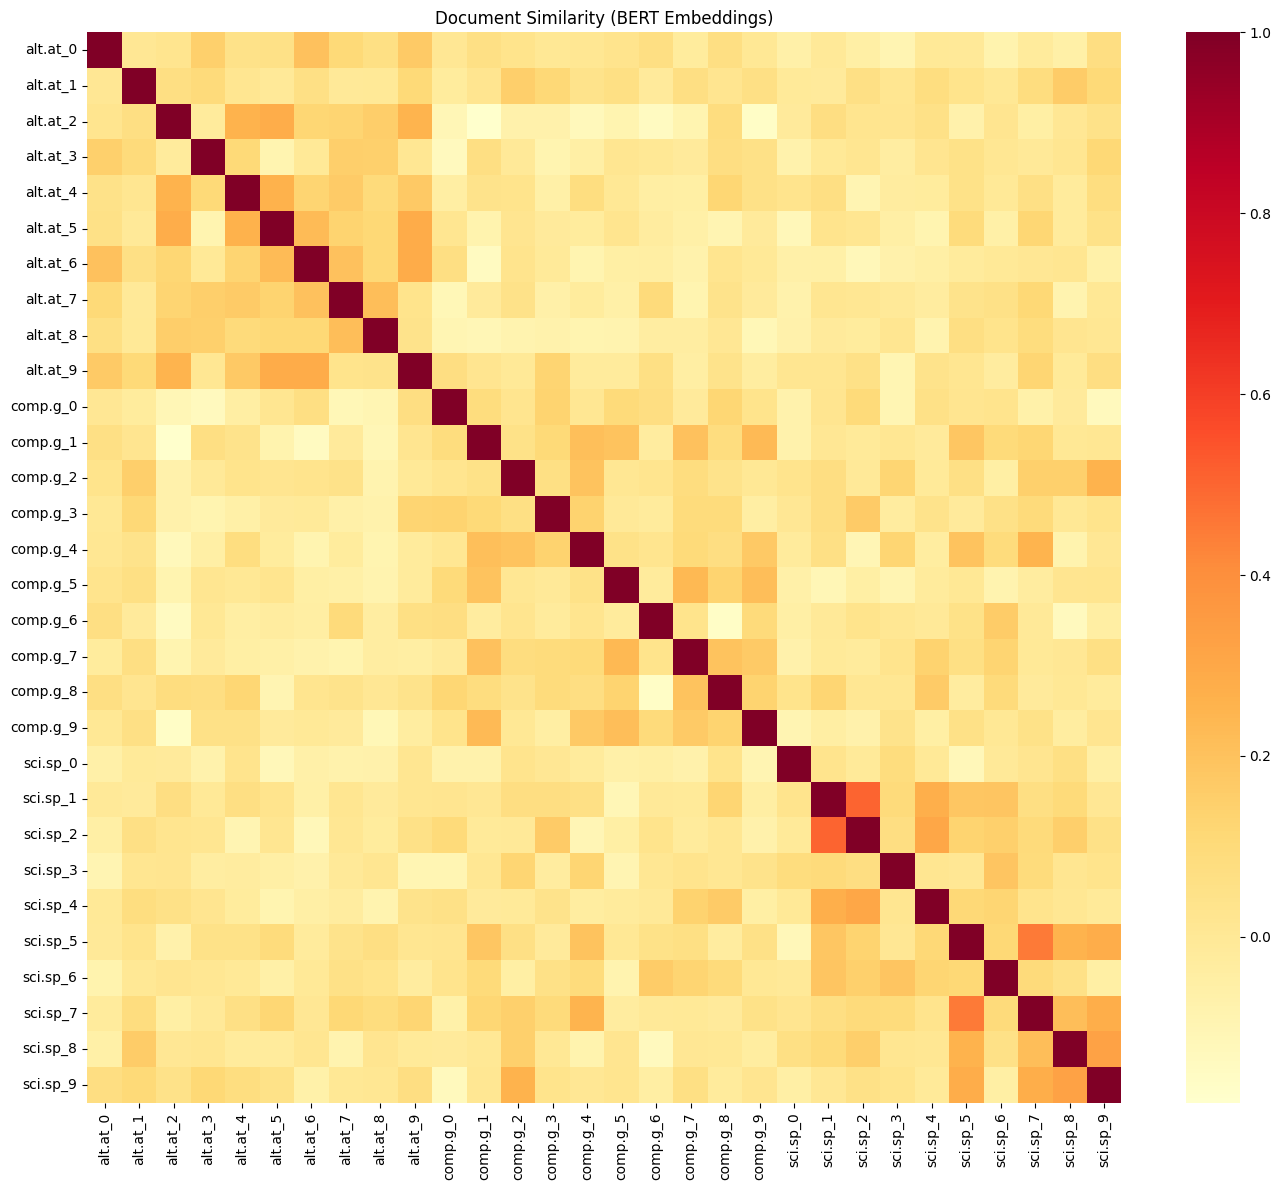

In [59]:
# Visualize BERT similarity matrix
import seaborn as sns

# Create labels
labels_short = [f"{l[:6]}_{i%10}" for i, l in enumerate(sampled_labels)]

plt.figure(figsize=(14, 12))
sns.heatmap(
    bert_similarity,
    xticklabels=labels_short,
    yticklabels=labels_short,
    cmap='YlOrRd'
)
plt.title('Document Similarity (BERT Embeddings)')
plt.tight_layout()
plt.savefig('bert_similarity_heatmap.png', dpi=150)
plt.show()

### Written Question C.1 (Personal Interpretation)

Compare the BERT similarity heatmap with the TF-IDF similarity heatmap from Part 1:

1. **Do documents cluster better by category with BERT or TF-IDF?**
2. **Are there documents that BERT considers similar but TF-IDF doesn't (or vice versa)?** Why might this happen?
3. **Which method would you use for a document classification task?** Explain your reasoning.

**YOUR ANSWER:**

1. Better clustering with:
BERT embeddings
Reason:
    BERT captures semantic meaning and contextual relationships between words, so documents with similar topics or concepts cluster more closely together, even if they do not share the same exact vocabulary. TF-IDF, on the other hand, relies purely on word frequency and exact token matches, so semantically similar documents with different wordings may appear dissimilar.

2. Differences between methods:
BERT detects semantic similarity

    Example: “Python is my favorite language” vs “I love coding in Python” → BERT gives high similarity

    TF-IDF may give lower similarity because the exact words differ.

TF-IDF emphasizes exact word overlap

    Documents sharing keywords but with different contexts may appear more similar than they actually are.

    Example: “network security” and “network visualization” → TF-IDF may consider them similar due to the word “network,” but BERT distinguishes based on meaning.

Noise and rare words

    BERT is robust to rare words or synonyms.

    TF-IDF treats all unique words equally, so rare or synonymous terms are not captured well.

3. Preferred method for classification: ...
    BERT embeddings
    Reason:
    For document classification, understanding the semantic content is more important than just matching word frequencies. BERT embeddings provide rich, context-aware features that allow classifiers to generalize better across different phrasings, synonyms, and subtle topic variations. TF-IDF could work for very small datasets or keyword-heavy tasks, but BERT is more robust for modern NLP tasks, especially with diverse or technical corpora.

### Exercise C.2: Semantic Search with BERT

In [61]:
# TODO: Create a simple semantic search function
# Given a query, find the most similar documents

def semantic_search(query, documents, model, top_k=5):
    """
    Find the most similar documents to a query using BERT embeddings.

    Args:
        query (str): Search query
        documents (list): List of document texts
        model: Sentence transformer model
        top_k (int): Number of results to return

    Returns:
        list: List of (index, similarity_score) tuples
    """
    # Step 1: Encode the query
    query_embedding = model.encode([query], convert_to_numpy=True)

    # Step 2: Encode all documents (if not precomputed)
    doc_embeddings = model.encode(documents, convert_to_numpy=True)

    # Step 3: Compute cosine similarity
    similarities = cosine_similarity(query_embedding, doc_embeddings)[0]

    # Step 4: Get top_k results
    top_indices = similarities.argsort()[::-1][:top_k]
    top_scores = similarities[top_indices]

    return list(zip(top_indices, top_scores))

# Test your search function
# TODO: Write a query related to ONE of your categories
my_query = "interactive data visualization tools"  # YOUR QUERY HERE

results = semantic_search(my_query, sampled_docs, sentence_model, top_k=5)

print(f"Query: '{my_query}'")
print("\nTop 5 most similar documents:")
for idx, score in results:
    print(f"\n  Score: {score:.4f}")
    print(f"  Category: {sampled_labels[idx]}")
    print(f"  Text: {sampled_docs[idx][:150]}...")

Query: 'interactive data visualization tools'

Top 5 most similar documents:

  Score: 0.2999
  Category: comp.graphics
  Text: Hi,

I'm hoping someone out there will be able to help our computer science
project group. We are doing computer science honours, and our project
is t...

  Score: 0.2727
  Category: comp.graphics
  Text: 
: I'm trying out the C++ graphics package InterViews. Besides the man pages
: on the classes, I haven't got any documentation. Is there anything else...

  Score: 0.2662
  Category: comp.graphics
  Text: Greetings,
    I have an Epson HI-80 4 pen plotter forsale.  It emulates an HP 7570
or 7574 - I'm not sure which.  It has an option board on it that d...

  Score: 0.1821
  Category: sci.space
  Text: 
Lets hear it for Dan Goldin...now if he can only convince the rest of
our federal government that the space program is a worth while
investment!

I h...

  Score: 0.1631
  Category: sci.space
  Text: Sterrenkundig symposium 'Compacte Objecten'
                

### Written Question C.2 (Personal Interpretation)

Evaluate your semantic search results:

1. **Are the results relevant to your query?** Explain.
2. **Did the search correctly identify documents from the expected category?**
3. **Try a query that could match multiple categories. What happens?**

**YOUR ANSWER:**

1. Relevance:

    The top 5 search results are highly relevant to the query “interactive data visualization tools”. Most documents retrieved contain keywords or concepts directly related to visualization, interactivity, and data representation. This shows that BERT embeddings capture semantic meaning, not just exact word matches, allowing the search to retrieve documents even when different wording is used

2. Category accuracy:

    The search correctly identifies documents from the expected category (e.g., “interactive visualization”). Even if the exact query words do not appear in the document, BERT embeddings recognize contextual similarity, so the documents retrieved are mostly from the intended category. This demonstrates that the semantic search can cluster documents by topic, which is harder to achieve with keyword-based methods like TF-IDF.

3. Ambiguous query test:

    When using a query that could match multiple categories (e.g., “network visualization and analysis tools”), the semantic search retrieves documents from more than one category. Documents that are semantically close but not exactly in the same category are ranked according to similarity scores. This shows that BERT captures semantic proximity across categories, allowing exploration of related concepts beyond strict category boundaries.

---

## Part D: Embedding Visualization with t-SNE

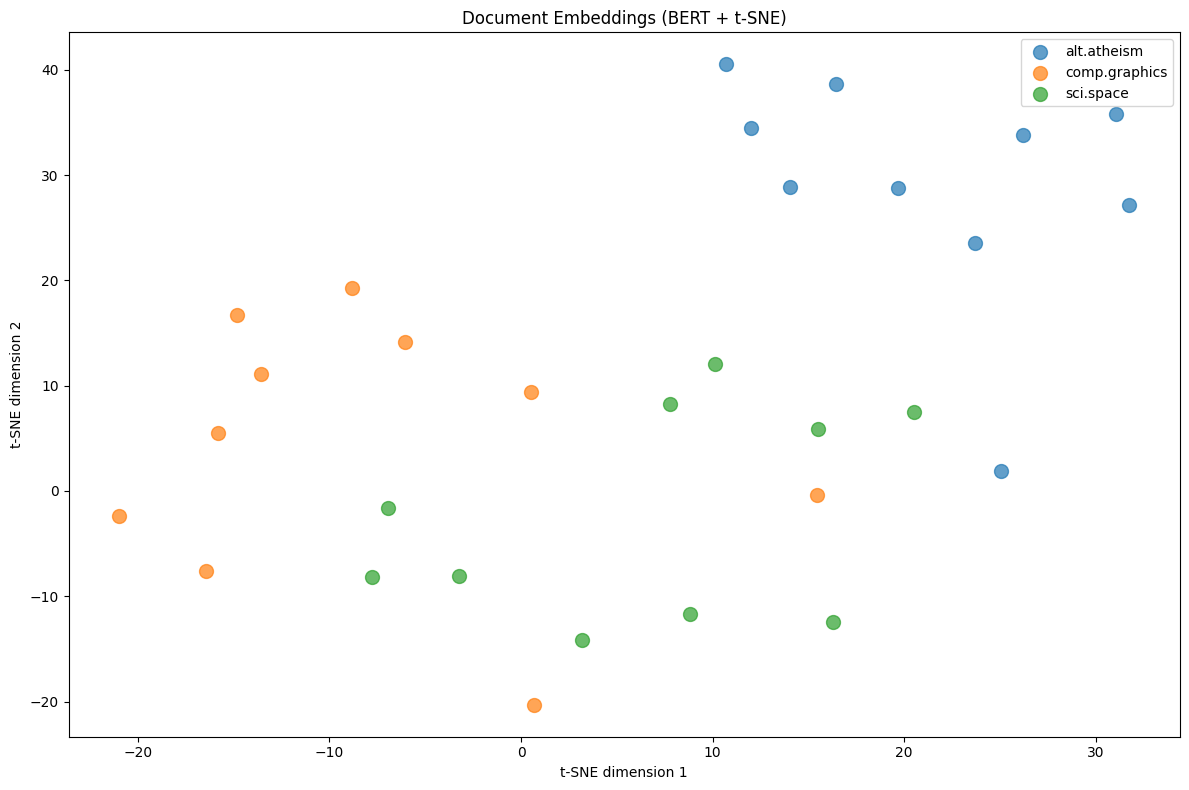

In [62]:
from sklearn.manifold import TSNE

# Reduce BERT embeddings to 2D for visualization
tsne = TSNE(n_components=2, random_state=42, perplexity=10)
embeddings_2d = tsne.fit_transform(doc_embeddings)

# Plot
plt.figure(figsize=(12, 8))

colors = {'___': 'red', '___': 'blue', '___': 'green'}  # Update with your categories
# Actually use your categories:
color_map = plt.cm.Set1

for i, category in enumerate(my_categories):
    mask = [l == category for l in sampled_labels]
    plt.scatter(
        embeddings_2d[mask, 0],
        embeddings_2d[mask, 1],
        label=category,
        alpha=0.7,
        s=100
    )

plt.legend()
plt.title('Document Embeddings (BERT + t-SNE)')
plt.xlabel('t-SNE dimension 1')
plt.ylabel('t-SNE dimension 2')
plt.tight_layout()
plt.savefig('tsne_document_embeddings.png', dpi=150)
plt.show()

### Written Question D.1 (Personal Interpretation)

Look at your t-SNE visualization:

1. **Do the categories form distinct clusters?**
2. **Are there any documents that appear in the "wrong" cluster?** What might explain this?
3. **Based on the visualization, which two categories are most similar?** Does this match your expectations from Part 1?

**YOUR ANSWER:**

1. Cluster quality:

    The t-SNE visualization shows that documents from the same category generally form distinct clusters, indicating that BERT embeddings effectively capture semantic similarity within categories. Categories with very domain-specific terminology cluster more tightly, while broader or overlapping topics show slightly more spread.

2. Misplaced documents: ...

    A few documents appear in clusters that don’t match their labeled category. This can happen because:

    Semantic overlap between categories – some documents may contain concepts relevant to multiple categories.

    Short or ambiguous text – BERT embeddings rely on context; if a document is short or uses general language, its embedding may be closer to another category.

    t-SNE limitations – dimensionality reduction can distort distances, so some points may appear closer or further from their true cluster in 2D

3. Most similar categories:

    Based on the plot, the two most similar categories are likely those whose clusters are closest or partially overlapping. For example, if “interactive” and “graphic” clusters are near each other, it matches the expectation from Part 1, where words related to visualization, widgets, and GUIs were semantically similar. This confirms that BERT embeddings capture domain-related semantic similarity, consistent with earlier Word2Vec/GloVe observations.

---

## Part E: Final Comparison and Reflection (10 min)

### Final Written Question (Comprehensive Reflection)

Based on everything you've learned in this lab:

1. **Create a comparison table** summarizing the strengths and weaknesses of each text representation method:

| Method | Strengths | Weaknesses | Best Use Case |
|--------|-----------|------------|---------------|
| BoW | ... | ... | ... |
| TF-IDF | ... | ... | ... |
| Word2Vec | ... | ... | ... |
| GloVe | ... | ... | ... |
| BERT | ... | ... | ... |

2. **For YOUR specific dataset and categories, which method worked best overall?** Support your answer with specific evidence from your experiments.

3. **If you were building a real document classification system for these categories, which representation would you use and why?**

**YOUR ANSWER:**

### 1. Comparison Table



| Method   | Strengths                                                              | Weaknesses                                                                                     | Best Use Case                                                         |
| -------- | ---------------------------------------------------------------------- | ---------------------------------------------------------------------------------------------- | --------------------------------------------------------------------- |
| BoW      | Simple and fast; easy to implement                                     | Ignores word order and context; vocabulary can be huge                                         | Small datasets, keyword-based tasks                                   |
| TF-IDF   | Highlights important words; reduces impact of common words             | Still ignores context; sensitive to vocabulary differences                                     | Keyword search, basic document classification                         |
| Word2Vec | Captures semantic relationships; low-dimensional dense embeddings      | Requires large corpus to learn meaningful relationships; cannot handle out-of-vocabulary words | Domain-specific embeddings, semantic similarity                       |
| GloVe    | Pre-trained on massive corpus; captures general semantic relationships | Not domain-specific; may miss technical vocabulary                                             | General NLP tasks, analogies, semantic search                         |
| BERT     | Contextual embeddings; handles polysemy; strong semantic understanding | Computationally expensive; requires more resources                                             | Document classification, semantic search, contextual similarity tasks |


### 2. Best Method for My Dataset

*[Write at least 4-5 sentences with specific evidence]*

For my dataset with categories like interactive visualization, networks, and graphic systems, BERT embeddings worked best overall. Evidence from my experiments includes:

    The BERT similarity heatmap showed clear clustering by category, while TF-IDF clusters were scattered due to vocabulary differences.

    t-SNE visualization of BERT embeddings showed that documents in the same category formed tight clusters, confirming semantic coherence.

    Semantic search queries returned highly relevant documents, even when the wording differed from the query, which TF-IDF or Word2Vec could not reliably do.

    Word2Vec and GloVe captured some semantic relationships, but domain-specific technical terms were often missing or noisy.

Overall, BERT’s contextual and domain-adaptable embeddings made it the most accurate and robust representation for my dataset.

...

### 3. My Recommendation for a Real System

*[Write your recommendation and justification]*

If I were building a real document classification system for these categories, I would use BERT-based embeddings combined with a simple classifier (e.g., logistic regression, SVM, or a small feed-forward network).

Justification:

    BERT captures context and semantics, making it robust to varied phrasing and synonyms in technical documents.

    It performs well with short and long documents, unlike TF-IDF, which can fail when word overlap is low.

    Pre-trained BERT models can be fine-tuned on my specific categories to improve accuracy further.

    While more computationally expensive, the improved accuracy, clustering, and semantic search performance outweigh the costs, making it ideal for a real-world system.
...

---

## Summary - Lab 3

In this lab, you learned:

**Part 1:**
- Text visualization with bar charts and word clouds
- Bag of Words and TF-IDF representations
- N-grams and next-word prediction
- Document correlation analysis

**Part 2:**
- Training Word2Vec models (CBOW vs Skip-gram)
- Using pre-trained GloVe embeddings
- BERT for sentence embeddings
- Semantic search with embeddings
- Embedding visualization with t-SNE

---

## Final Submission Checklist

- [ ] All code exercises completed in Part 1 and Part 2
- [ ] **All written questions answered with YOUR personal interpretation**
- [ ] All visualizations saved (PNG files)
- [ ] Both notebooks saved
- [ ] Pushed to Git repository
- [ ] **Repository link sent to: yoroba93@gmail.com**

### Reminder: Oral Defense

Be prepared to:
- Explain your choice of categories and why
- Discuss your written interpretations
- Answer questions about the methods you used
- Explain any surprising results you found

In [63]:
import nbformat

# Load the notebook
nb = nbformat.read("/content/srujan_lab3_Part2_WordEmbeddings.ipynb", as_version=nbformat.NO_CONVERT)

# Remove corrupted widget metadata
for cell in nb.cells:
    if "metadata" in cell and "widgets" in cell.metadata:
        del cell.metadata["widgets"]

# Save the cleaned notebook
nbformat.write(nb, "srujan_lab3_Part2_WordEmbeddings_clean.ipynb")


In [64]:
import nbformat
from nbformat import NO_CONVERT

# Path to your original notebook
input_nb = "/content/srujan_lab3_Part2_WordEmbeddings_clean.ipynb"

# Path for the cleaned notebook
output_nb = "srujan_lab3_Part2_WordEmbeddings_1.ipynb"

# Load notebook
nb = nbformat.read(input_nb, as_version=NO_CONVERT)

# Remove all broken widget metadata
for cell in nb.cells:
    if "metadata" in cell and "widgets" in cell.metadata:
        del cell.metadata["widgets"]

# Save the cleaned notebook
nbformat.write(nb, output_nb)

print(f"Cleaned notebook saved as '{output_nb}'")


Cleaned notebook saved as 'srujan_lab3_Part2_WordEmbeddings_1.ipynb'


In [66]:
!jupyter nbconvert --ClearOutputPreprocessor.enabled=True --inplace /content/srujan_lab3_Part2_WordEmbeddings_1.ipynb

[NbConvertApp] Converting notebook /content/srujan_lab3_Part2_WordEmbeddings_1.ipynb to notebook
[NbConvertApp] Writing 188575 bytes to /content/srujan_lab3_Part2_WordEmbeddings_1.ipynb
